<a href="https://colab.research.google.com/github/ludoveltz/test_github_fev25/blob/main/Daily_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import des bibliothèques nécessaires
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

In [3]:
from google.colab import files
files.upload()  # Sélectionnez votre fichier kaggle.json quand la boîte de dialogue s'ouvre


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ludovicveltz","key":"9c26f1d362dfce6d6231dcac777aef90"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d olgabelitskaya/flower-color-images

Dataset URL: https://www.kaggle.com/datasets/olgabelitskaya/flower-color-images
License(s): other
 94% 47.0M/50.1M [00:02<00:00, 27.5MB/s]
100% 50.1M/50.1M [00:02<00:00, 18.9MB/s]


In [6]:
!unzip flower-color-images.zip


Archive:  flower-color-images.zip
  inflating: FlowerColorImages.h5    
  inflating: flower_images/flower_images/0001.png  
  inflating: flower_images/flower_images/0002.png  
  inflating: flower_images/flower_images/0003.png  
  inflating: flower_images/flower_images/0004.png  
  inflating: flower_images/flower_images/0005.png  
  inflating: flower_images/flower_images/0006.png  
  inflating: flower_images/flower_images/0007.png  
  inflating: flower_images/flower_images/0008.png  
  inflating: flower_images/flower_images/0009.png  
  inflating: flower_images/flower_images/0010.png  
  inflating: flower_images/flower_images/0011.png  
  inflating: flower_images/flower_images/0012.png  
  inflating: flower_images/flower_images/0013.png  
  inflating: flower_images/flower_images/0014.png  
  inflating: flower_images/flower_images/0015.png  
  inflating: flower_images/flower_images/0016.png  
  inflating: flower_images/flower_images/0017.png  
  inflating: flower_images/flower_images/001

In [7]:
!pip install tensorflow
!pip install keras
!pip install pillow

00_001.png  01_033.png	03_027.png  05_030.png	07_028.png  09_026.png	15_001.png  17_015.png
00_002.png  01_034.png	03_028.png  05_031.png	07_029.png  09_027.png	15_002.png  17_016.png
00_003.png  01_035.png	03_029.png  05_032.png	07_030.png  10_001.png	15_003.png  17_017.png
00_004.png  01_036.png	03_030.png  05_033.png	07_031.png  10_002.png	15_004.png  17_018.png
00_005.png  01_037.png	03_031.png  05_034.png	07_032.png  10_003.png	15_005.png  17_019.png
00_006.png  01_038.png	03_032.png  05_035.png	07_033.png  10_004.png	15_006.png  17_020.png
00_007.png  01_039.png	03_033.png  05_036.png	07_034.png  10_005.png	15_007.png  17_021.png
00_008.png  01_040.png	03_034.png  05_037.png	07_035.png  10_006.png	15_008.png  17_022.png
00_009.png  01_041.png	03_035.png  05_038.png	08_001.png  10_007.png	15_009.png  17_023.png
00_010.png  01_042.png	03_036.png  05_039.png	08_002.png  10_008.png	15_010.png  17_024.png
00_011.png  01_043.png	03_037.png  05_040.png	08_003.png  10_009.png	15_011.png 

(-0.5, 127.5, 127.5, -0.5)

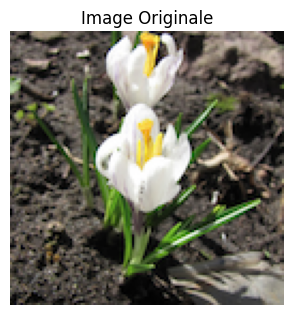

In [9]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate

# Vérification du contenu du dossier
!ls flowers/flowers

# Chargement de l'image
image_path = 'flowers/flowers/19_010.png'  # Ajustez le chemin si nécessaire
original_image = Image.open(image_path)

plt.figure(figsize=(12, 10))
plt.subplot(2, 3, 1)
plt.title('Image Originale')
plt.imshow(original_image)
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

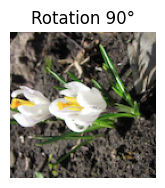

In [10]:
# 2. Rotation de l'image de 90 degrés
def rotate_image_90_degrees(image):
    # Convertir l'image PIL en array numpy
    image_array = np.array(image)
    # Rotation de 90 degrés
    rotated = rotate(image_array, 90, reshape=True, mode='nearest')
    return Image.fromarray(rotated)

rotated_image = rotate_image_90_degrees(original_image)
plt.subplot(2, 3, 2)
plt.title('Rotation 90°')
plt.imshow(rotated_image)
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

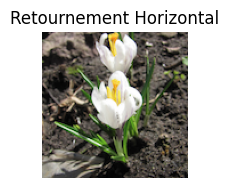

In [11]:
# 3. Retournement horizontal
flipped_h = ImageOps.mirror(original_image)
plt.subplot(2, 3, 3)
plt.title('Retournement Horizontal')
plt.imshow(flipped_h)
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

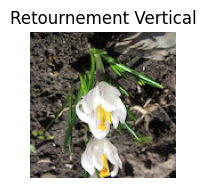

In [12]:
# 4. Retournement vertical
flipped_v = ImageOps.flip(original_image)
plt.subplot(2, 3, 4)
plt.title('Retournement Vertical')
plt.imshow(flipped_v)
plt.axis('off')

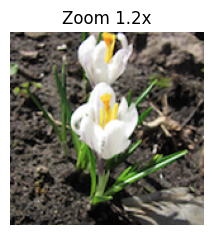

In [13]:
# 5. Zoom (échelle 1.2x)
width, height = original_image.size
new_width = int(width * 1.2)
new_height = int(height * 1.2)
zoomed_image = original_image.resize((new_width, new_height), Image.Resampling.LANCZOS)

plt.subplot(2, 3, 5)
plt.title('Zoom 1.2x')
plt.imshow(zoomed_image)
plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Sauvegarde des images modifiées
rotated_image.save('fleur_rotated.png')
flipped_h.save('fleur_flipped_h.png')
flipped_v.save('fleur_flipped_v.png')
zoomed_image.save('fleur_zoomed.png')